# Project: Crime Rate Prediction
**Name:** Wahid Hashem, Aryan Sharma, Zewen Wang
**Date:** 12/5/2025
**Course:** STT 810

### Description
This project analyzes the "Communities and Crime" dataset from UCI repository. It uses Principal Component Analysis (PCA) to reduce 100+ features into key components and compares the performance of Linear Regression vs. Logistic Regression in predicting high-crime areas.

### Complex Aspects Demonstrated
1. **Feature Engineering:** Created a binary target variable from continuous crime data.
2. **Hyperparameter Tuning:** Automated selection of PCA components based on variance thresholds.
3. **Model Comparison:** Evaluated Linear vs. Logistic regression performance on reduced feature sets.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)

# Load Data
X_normalized = pd.read_csv("crime_normalized_features.csv")
Y_normalized = pd.read_csv("crime_normalized_targets.csv")

# Clean Data (Replace "?" with NaN)
X_normalized = X_normalized.replace("?", np.nan)

# Convert to Numeric
X = X_normalized.apply(pd.to_numeric, errors="coerce")
Y = Y_normalized['ViolentCrimesPerPop'] # already numeric

# Drop Features with many Missing Values (>85%)
X = X.dropna(axis = 1)

# Drop Metadata Columns (Useless for PCA)
drop_cols = ['state', 'county', 'community', 'communityname', 'fold']
X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")

print(f"Data shape after cleaning: {X.shape}")

Data shape after cleaning: (1994, 99)


In [3]:
# PCA Analysis
pca = PCA()
X_pca = pca.fit_transform(X)

# Variance Explained
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


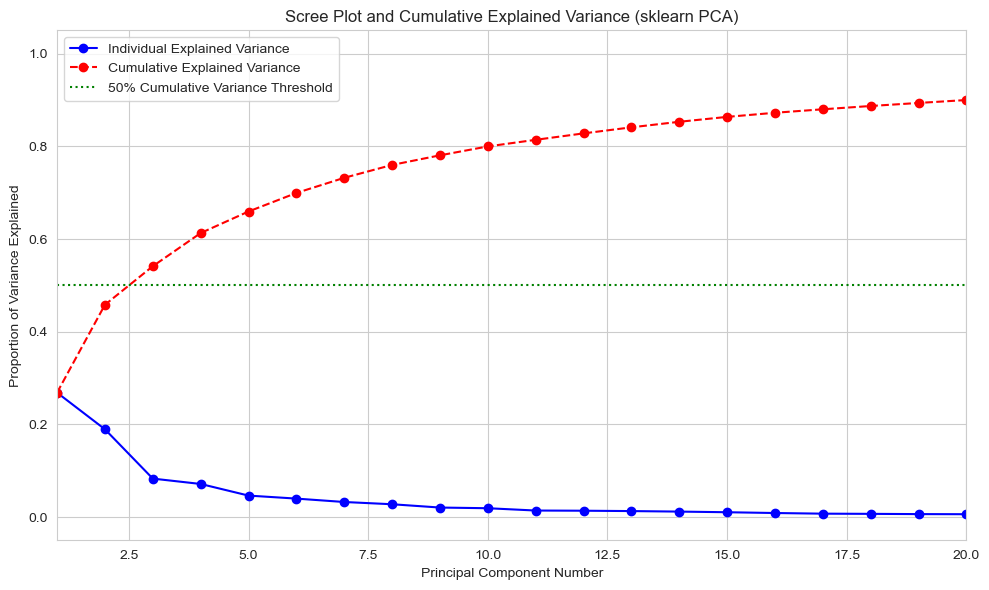

In [4]:
# Scree Plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

components = range(1, len(explained_variance) + 1)
plt.plot(
    components,
    explained_variance,
    marker="o",
    linestyle="-",
    color="b",
    label="Individual Explained Variance",
)
plt.plot(
    components,
    cumulative_variance,
    marker="o",
    linestyle="--",
    color="r",
    label="Cumulative Explained Variance",
)
plt.axhline(y=0.50, color="g", linestyle=":", label="50% Cumulative Variance Threshold") # 50% Threshold

plt.title("Scree Plot and Cumulative Explained Variance (sklearn PCA)")
plt.xlabel("Principal Component Number")
plt.ylabel("Proportion of Variance Explained")
plt.legend()
plt.grid(True)
plt.xlim(1, 20)
plt.tight_layout()
plt.show()


In [17]:
# Identify Top Features Driving PC1, PC2, and PC3
loadings = pca.components_.T
# Get loadings for PC1, PC2, and PC3
loadings_pc1_pc2_pc3 = loadings[:, :3]

# Calculate magnitudes of loadings across 3 components
magnitudes = np.sqrt(loadings_pc1_pc2_pc3[:, 0] ** 2 + loadings_pc1_pc2_pc3[:, 1] ** 2 + loadings_pc1_pc2_pc3[:, 2] ** 2)

features_df = pd.DataFrame(
    {
        "Feature": X.columns,
        "PC1_Loading": loadings_pc1_pc2_pc3[:, 0],
        "PC2_Loading": loadings_pc1_pc2_pc3[:, 1],
        "PC3_Loading": loadings_pc1_pc2_pc3[:, 2],
        "Strength": magnitudes,
    }
)

top_10 = features_df.sort_values(by="Strength", ascending=False).head(10)
print("Top 10 Features Driving PC1, PC2, and PC3:")
print(
    top_10[["Feature", "Strength", "PC1_Loading", "PC2_Loading", "PC3_Loading"]].to_string(index=False)
)

Top 10 Features Driving PC1, PC2, and PC3:
            Feature  Strength  PC1_Loading  PC2_Loading  PC3_Loading
           pctUrban  0.324784    -0.152898     0.179951    -0.222990
        racePctHisp  0.267742     0.061616     0.190124     0.178164
   PctSpeakEnglOnly  0.260683    -0.021832    -0.216733    -0.143198
       PctRecImmig8  0.256593    -0.006481     0.255743     0.019840
      PctRecImmig10  0.256013    -0.003869     0.254171     0.030414
PctNotSpeakEnglWell  0.255979     0.045832     0.209654     0.139536
       PctRecImmig5  0.253663    -0.003422     0.253281     0.013495
     PctForeignBorn  0.251144    -0.029213     0.241657     0.061824
     PctRecentImmig  0.249111    -0.006043     0.249026     0.002400
  PctLargHouseOccup  0.244770     0.048957     0.136034     0.197510


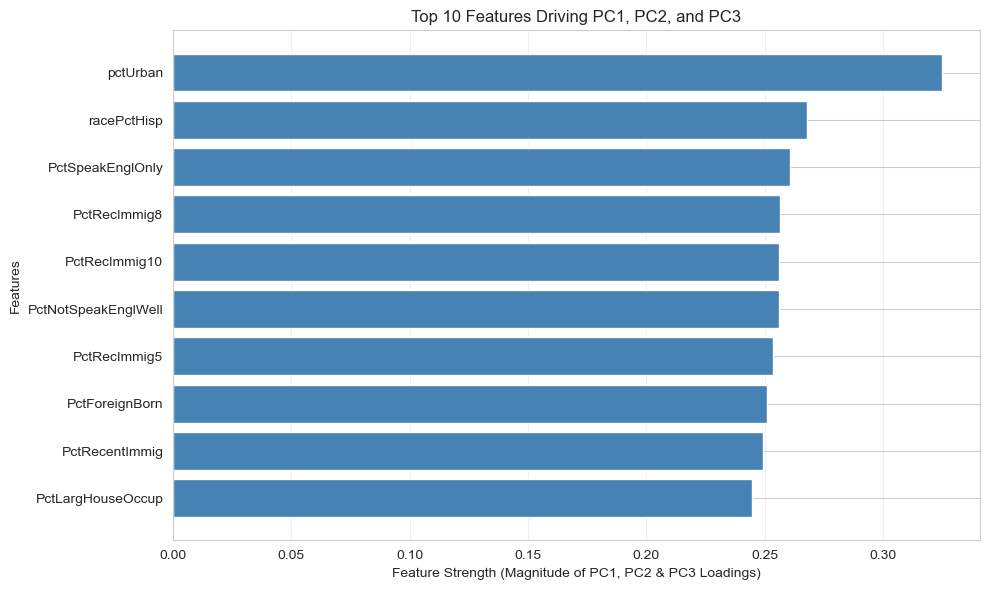

In [18]:
# Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(top_10)), top_10['Strength'].values, color='steelblue')
plt.yticks(range(len(top_10)), top_10['Feature'].values)
plt.xlabel('Feature Strength (Magnitude of PC1, PC2 & PC3 Loadings)')
plt.ylabel('Features')
plt.title('Top 10 Features Driving PC1, PC2, and PC3')
plt.gca().invert_yaxis()  # Highest strength at the top
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
# Loadings Heatmap for 3 Components
plt.figure(figsize=(10, 6))
loadings_top10 = top_10[['PC1_Loading', 'PC2_Loading', 'PC3_Loading']].T
sns.heatmap(loadings_top10, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            xticklabels=top_10['Feature'].values, cbar_kws={'label': 'Loading Value'})
plt.title('PCA Loadings Heatmap - Top 10 Features (3 Components)')
plt.ylabel('Principal Components')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

In [7]:
# Linear Regression Model
print("\n--- Linear Regression ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Pipeline
pipe_linear = Pipeline([
    ('pca', PCA(n_components=3)), 
    ('lin_reg', LinearRegression())
])

# Fit & Predict
pipe_linear.fit(X_train, y_train)
y_pred = pipe_linear.predict(X_test)


# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")


--- Linear Regression ---
MSE: 0.0241
R2 Score: 0.4961


In [12]:
# Logistic Regression Model
print("\n--- Logistic Regression ---")

# Binarize Target Variable based on Median
threshold = Y.median()
y_binary = (Y > threshold).astype(int)

# Split Data
X_train, X_test, y_train_cont, y_test_cont = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Binarize Target
y_train_bin = (y_train_cont > threshold).astype(int)
y_test_bin = (y_test_cont > threshold).astype(int)

# Pipeline
pipe_logistic = Pipeline([
    ('pca', PCA(n_components=3)),
    ('log_reg', LogisticRegression())
])

# Fit & Predict
pipe_logistic.fit(X_train, y_train_bin)
y_pred_log = pipe_logistic.predict(X_test)

# Evaluate
acc_logistic = accuracy_score(y_test_bin, y_pred_log)
print(f"Logistic Regression Accuracy: {acc_logistic:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred_log))


--- Logistic Regression ---
Logistic Regression Accuracy: 0.7995

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       224
           1       0.77      0.77      0.77       175

    accuracy                           0.80       399
   macro avg       0.80      0.80      0.80       399
weighted avg       0.80      0.80      0.80       399




--- Final Model Comparison (3 PCs) ---
Linear Regression (Thresholded) Accuracy: 0.7569
Logistic Regression Accuracy:             0.7995

--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       224
           1       0.77      0.77      0.77       175

    accuracy                           0.80       399
   macro avg       0.80      0.80      0.80       399
weighted avg       0.80      0.80      0.80       399

Number of PCA components used: 3
Variance explained by 3 components: 54.13%


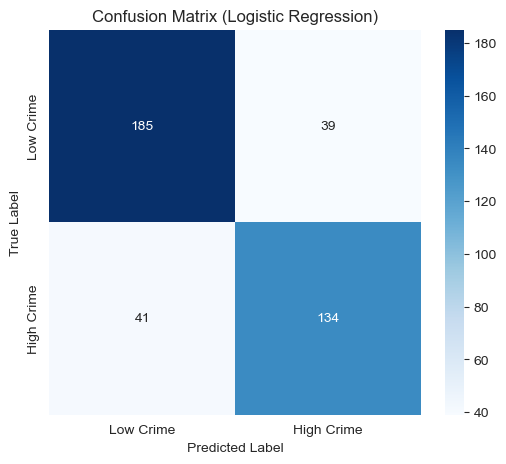

In [ ]:
# Model Comparison
print("\n--- Final Model Comparison (3 PCs) ---")

# Determine Threshold for Binary Classification
threshold = Y.median()

# Split Data
X_train, X_test, y_train_cont, y_test_cont = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Create Binary Targets for Logistic Regression
y_train_bin = (y_train_cont > threshold).astype(int)
y_test_bin = (y_test_cont > threshold).astype(int)

# Linear Regression
pipe_linear = Pipeline([
    ('pca', PCA(n_components=3)),       
    ('lin_reg', LinearRegression())
])
pipe_linear.fit(X_train, y_train_cont) 
y_pred_cont = pipe_linear.predict(X_test)
y_pred_linear_bin = (y_pred_cont > threshold).astype(int) 
acc_linear = accuracy_score(y_test_bin, y_pred_linear_bin)

# Logistic Regression
pipe_logistic = Pipeline([
    ('pca', PCA(n_components=3)),      
    ('log_reg', LogisticRegression())
])
pipe_logistic.fit(X_train, y_train_bin) 
y_pred_log = pipe_logistic.predict(X_test)
acc_logistic = accuracy_score(y_test_bin, y_pred_log)

# Accuracy Comparison
print(f"Linear Regression (Thresholded) Accuracy: {acc_linear:.4f}")
print(f"Logistic Regression Accuracy:             {acc_logistic:.4f}")

print("\n--- Logistic Regression Report ---")
print(classification_report(y_test_bin, y_pred_log))

print(f"Number of PCA components used: 3")
print(f"Variance explained by 3 components: {cumulative_variance[2]:.2%}")

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred_log)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Low Crime', 'High Crime'],
    yticklabels=['Low Crime', 'High Crime'])
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

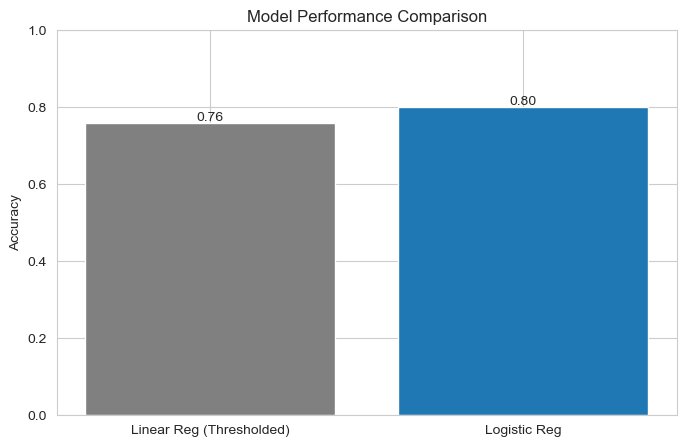

In [10]:
# Model Comparison Bar Chart
models = ['Linear Reg (Thresholded)', 'Logistic Reg']
accuracies = [acc_linear, acc_logistic]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['gray', '#1f77b4'])
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.bar_label(bars, fmt='%.2f')
plt.show()

### References
1. **Dataset:** Communities and Crime Dataset (UCI Machine Learning Repository).
2. **Libraries:** Scikit-learn, Pandas, NumPy, Seaborn.